In [1]:
from monai.utils import first, set_determinism
from monai.transforms import (
    AddChanneld,
    AsChannelFirstd,
    AsDiscrete,
    AsDiscreted,
    Compose,
    EnsureChannelFirstd,
    EnsureTyped,
    EnsureType,
    Invertd,
    Lambdad,
    LoadImaged,
    RandFlipd,
    RandSpatialCropd,
    RandZoomd,
    Resized,
    ScaleIntensityRanged,
    SpatialCrop,
    SpatialCropd,
    ToTensord,
)
from monai.handlers.utils import from_engine
from monai.networks.nets import UNETR
from monai.networks.layers import Norm
from monai.metrics import DiceMetric
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai.data import CacheDataset, DataLoader, Dataset, decollate_batch
from monai.config import print_config
from monai.apps import download_and_extract
import monai.utils as utils

import torch
import matplotlib.pyplot as plt
import tempfile
import shutil
import os
from glob import glob

import itk
from itk import TubeTK as ttk

import numpy as np
from scipy.ndimage import rotate
import site
import ubelt as ub
import pint
site.addsitedir('../../../ARGUS')
from ARGUS_Transforms import ARGUS_RandSpatialCropSlicesd  #NOQA
Ureg = pint.UnitRegistry()

In [2]:
img1_dir = "../../Data_ONSD/Preprocessed/Resized_224x224/"
img2_dir = "../../Data_ONSD/Annotations/CLEANED/Resized_224x224/"
    
all_images = sorted(glob(os.path.join(img1_dir, '*_cropM.nii.gz')))
all_labels = sorted(glob(os.path.join(img2_dir, '*.overlay.nii.gz')))

num_devices = 1
gpu_device = 1
runs = 3

num_classes = 3

net_in_dims = 2 # Spatial Dimensions
net_in_channels = 6 # Mean, Std, RawFrame, Gradient
net_channels=(16, 32, 64, 128, 32)
net_strides=(2, 2, 2, 2)
        
num_folds = 15

num_slice = 3
size_x = 224
size_y = 224

num_workers_te = 2
batch_size_te = 2

In [3]:
num_images = len(all_images)
print("Num images / labels =", num_images, len(all_labels))

p_prefix = [
    ' 239',
    ' 36',
    ' 40',
    ' 50',
    ' 64',
    ' 66',
    ' 87',
    ' 106',
    ' 117',
    ' 139',
    ' 158',
    ' 165',
    ' 107',
    ' 130',
    ' 146',
]
n_prefix = [
    ' 23',
    ' 108',
    ' 119',
    ' 129',
    ' 163',
    ' 191',
    ' 228',
    ' 250',
    ' 205',
    ' 209',
    ' 213',
    ' 215',
]


fold_prefix_list = []
p_count = 0
n_count = 0
for i in range(num_folds):
    num_p = 1
    num_n = 1
    if i > num_folds - 2:
        if i % 2 == 0 and p_count + 2 < len(p_prefix):
            num_p = 2
            num_n = 1
        else:
            num_p = 1
            num_n = 1
    f = []
    if p_count < len(p_prefix):
        for p in range(num_p):
            f.append([p_prefix[p_count+p]])
    p_count += num_p
    if n_count < len(n_prefix):
        for n in range(num_n):
            f.append([n_prefix[n_count+n]])
    n_count += num_n
    fold_prefix_list.append(f)

for i in range(num_folds):
    print(i, fold_prefix_list[i])

Num images / labels = 33 33
0 [[' 239'], [' 23']]
1 [[' 36'], [' 108']]
2 [[' 40'], [' 119']]
3 [[' 50'], [' 129']]
4 [[' 64'], [' 163']]
5 [[' 66'], [' 191']]
6 [[' 87'], [' 228']]
7 [[' 106'], [' 250']]
8 [[' 117'], [' 205']]
9 [[' 139'], [' 209']]
10 [[' 158'], [' 213']]
11 [[' 165'], [' 215']]
12 [[' 107']]
13 [[' 130']]
14 [[' 146']]


In [4]:
total_bytes = 0
for p in all_images:
    p = ub.Path(p)
    total_bytes += p.stat().st_size
print((total_bytes * Ureg.byte).to('GiB'))

total_bytes = 0
for p in all_labels:
    p = ub.Path(p)
    total_bytes += p.stat().st_size
print((total_bytes * Ureg.byte).to('GiB'))

1.5098263649269938 gibibyte
0.0024493765085935593 gibibyte


In [5]:
train_files = []
val_files = []
test_files = []

for i in range(num_folds):
    tr_folds = []
    va_folds = []
    for f in range(i,i+num_folds-3):
        tr_folds.append(fold_prefix_list[f%num_folds])
    tr_folds = list(np.concatenate(tr_folds).flat)
    for f in range(i+num_folds-3, i+num_folds-1):
        va_folds.append(fold_prefix_list[f%num_folds])
    va_folds = list(np.concatenate(va_folds).flat)
    te_folds = list(np.concatenate(fold_prefix_list[(i+num_folds-1) % num_folds]).flat)
    train_files.append(
            [
                {"image": img, "label": seg}
                for img, seg in zip(
                    [im for im in all_images if any(pref in im for pref in tr_folds)],
                    [se for se in all_labels if any(pref in se for pref in tr_folds)])
            ]
        )
    val_files.append(
            [
                {"image": img, "label": seg}
                for img, seg in zip(
                    [im for im in all_images if any(pref in im for pref in va_folds)],
                    [se for se in all_labels if any(pref in se for pref in va_folds)])
            ]
        )
    test_files.append(
            [
                {"image": img, "label": seg}
                for img, seg in zip(
                    [im for im in all_images if any(pref in im for pref in te_folds)],
                    [se for se in all_labels if any(pref in se for pref in te_folds)])
            ]
        )
    print(
        len(train_files[i]), " | ",
        len(val_files[i]), " | ",
        len(test_files[i]), " | ",
        len(train_files[i]) + len(val_files[i]) + len(test_files[i])
    )

28  |  3  |  1  |  32
25  |  3  |  4  |  32
25  |  5  |  2  |  32
24  |  6  |  2  |  32
26  |  4  |  2  |  32
26  |  4  |  2  |  32
26  |  4  |  2  |  32
26  |  4  |  2  |  32
24  |  4  |  4  |  32
24  |  6  |  2  |  32
24  |  6  |  2  |  32
26  |  4  |  2  |  32
26  |  4  |  2  |  32
27  |  4  |  1  |  32
27  |  3  |  2  |  32


In [6]:
test_transforms = Compose(
[
        LoadImaged(keys=["image", "label"]),
        AsChannelFirstd(keys='image'),
        AsChannelFirstd(keys='label'),
        ScaleIntensityRanged(
            a_min=0, a_max=255,
            b_min=0.0, b_max=1.0,
            keys=["image"]),
        ARGUS_RandSpatialCropSlicesd(
            num_slices=[num_slice,1],
            center_slice=-num_slice/2 - 1,
            axis=0,
            reduce_to_statistics=[True,False],
            extended=False,
            include_center_slice=True,
            include_gradient=True,
            keys=['image','label']),
        ToTensord(keys=["image", "label"],dtype=torch.float)
    ])

<class 'monai.transforms.utility.array.AsChannelFirst'>: Class `AsChannelFirst` has been deprecated since version 0.8. please use MetaTensor data type and monai.transforms.EnsureChannelFirst instead.


In [7]:
device = torch.device("cpu")

In [8]:
model_type = "best"  #"best" or "last"

def plot_vfold_training_curves(vfold_num, test_loader):
    print("VFOLD =", vfold_num, "of", num_folds - 1)
    with torch.no_grad():
        test_outputs_list = []
        test_images_list = []
        test_labels_list = []
        for run in range(0,runs):
            model_filename_base = "./results/BAMC_ONSD_ARViTUNet-Mean_StdDevOverTime_RawFrame_Gradient-224x224-" + str(num_slice) + "s-VFold-Run" + str(run)
            model_filename_base = model_filename_base+"/"
            model_file = model_filename_base+model_type+'_model.vfold_'+str(vfold_num)+'.pth'
            if os.path.exists(model_file):
                model = UNETR(
                    img_size=(size_x,size_y),
                    spatial_dims=net_in_dims,
                    in_channels=net_in_channels,
                    out_channels=num_classes,
                    num_heads=12,
                    hidden_size=768,
                    mlp_dim=768 * 4,
                    feature_size=16,
                    norm_name=Norm.BATCH,
                ).to(device)
                dice_metric = DiceMetric(include_background=False, reduction="mean")
                post_pred = Compose([EnsureType(), AsDiscrete(argmax=True, to_onehot=num_classes)])
                post_label = Compose([EnsureType(), AsDiscrete(to_onehot=num_classes)])   
                model.load_state_dict(torch.load(model_file))
                model.eval()

                for b,test_data in enumerate(test_loader):
                    roi_size = (size_x, size_y)
                    sw_batch_size = 1
                    test_outputs = sliding_window_inference(
                        test_data["image"].to(device), roi_size, sw_batch_size, model
                    ).cpu()

                    if b == 0:
                        test_outputs_total = test_outputs
                        test_images_total = test_data["image"].to(device)
                        test_labels_total = test_data["label"].to(device)
                    else:
                        test_outputs_total = np.concatenate((test_outputs_total,test_outputs),axis=0)
                        test_images_total = np.concatenate((test_images_total,test_data["image"].to(device)),axis=0)
                        test_labels_total = np.concatenate((test_labels_total,test_data["label"].to(device)),axis=0)
                test_outputs_list.append(test_outputs_total)
                test_images_list.append(test_images_total)
                test_labels_list.append(test_labels_total)

        nerve_prior = 1
        class_nerve = 2

        min_size = 0
        max_size = 7000
        
        for img in range(0,test_outputs_list[0].shape[0]):
            fname = os.path.basename(
                test_files[vfold_num][img]["image"]
            )
            print("Image:", fname)

            plt.figure("check", (18, 6))
            num_subplots = (
                max(net_in_channels, runs * num_classes) + 3
            )  # 3 = blank + ensemble(needle) + pred
            subplot_num = 1
            for c in range(net_in_channels):
                plt.subplot(2, num_subplots, subplot_num)
                plt.title(f"image")
                tmpV = test_images_list[0][img, c, :, :]
                plt.axis('off')
                plt.imshow(rotate(tmpV,270), cmap="gray")
                subplot_num += 1
            plt.subplot(2, num_subplots, num_subplots)
            plt.title(f"label")
            print(test_labels_list[0].shape)
            tmpV = test_labels_list[0][img,0, :, :]
            print(tmpV.shape)
            for c in range(num_classes):
                tmpV[0, c] = c
            plt.axis('off')
            plt.imshow(rotate(tmpV,270))
            subplot_num += 1

            # Indent by one plot
            subplot_num = num_subplots + 1
            prob_shape = test_outputs_list[0][img].shape
            prob_total = np.zeros(prob_shape)
            for run_num in range(0,runs):
                prob = np.empty(prob_shape)
                run_output = test_outputs_list[run_num]
                for c in range(num_classes):
                    itkProb = itk.GetImageFromArray(run_output[img,c, :, :])
                    imMathProb = ttk.ImageMath.New(itkProb)
                    imMathProb.Blur(5)
                    itkProb = imMathProb.GetOutput()
                    prob[c] = itk.GetArrayFromImage(itkProb)
                pmin = prob.min()
                pmax = prob.max()
                prange = pmax - pmin
                prob = (prob - pmin) / prange
                prob[class_nerve] = prob[class_nerve] * nerve_prior
                class_array = np.zeros(prob_shape) # np.argmax(prob, axis=0)
                done = False
                while not done:
                    done = True
                    count = np.count_nonzero(class_array > 0)
                    while count < min_size:
                        prob[class_nerve] = prob[class_nerve] * 1.05
                        class_array = np.argmax(prob, axis=0)
                        count = np.count_nonzero(class_array == class_nerve)
                        done = False
                    while count > max_size:
                        prob[class_nerve] = prob[class_nerve] * 0.95
                        class_array = np.argmax(prob, axis=0)
                        count = np.count_nonzero(class_array == class_nerve)
                        done = False
                denom = np.sum(prob, axis=0)
                denom = np.where(denom == 0, 1, denom)
                prob = [prob[c] / denom for c in range(num_classes)]
                prob_total += prob
                for c in range(num_classes):
                    plt.subplot(2, num_subplots, subplot_num)
                    plt.title(f"Class " + str(c))
                    tmpV = prob[c]
                    plt.axis('off')
                    plt.imshow(rotate(tmpV,270), cmap="gray")
                    subplot_num += 1

            prob_total = prob_total / runs
            subplot_num = num_subplots * 2 - 1
            plt.subplot(2, num_subplots, subplot_num)
            plt.title(f"Ensemble")
            tmpV = prob_total[class_nerve, :, :]
            plt.axis('off')
            plt.imshow(rotate(tmpV,270), cmap="gray")
            subplot_num += 1

            class_array = np.argmax(prob_total, axis=0)
            class_image = itk.GetImageFromArray(class_array.astype(np.float32))
            imMathClassCleanup = ttk.ImageMath.New(class_image)
            imMathClassCleanup.Erode(5, class_nerve, 0)
            imMathClassCleanup.Dilate(5, class_nerve, 0)
            class_image = imMathClassCleanup.GetOutputUChar()

            imMathClassCleanup.Threshold(class_nerve, class_nerve, 1, 0)
            target_class_image = imMathClassCleanup.GetOutputUChar()

            seg = itk.itkARGUS.SegmentConnectedComponents.New(
                Input=target_class_image
            )
            seg.SetKeepOnlyLargestComponent(True)
            seg.Update()
            target_class_image = seg.GetOutput()
            target_class_array = itk.GetArrayFromImage(target_class_image)

            class_array = np.where(class_array == class_nerve, 0, class_array)
            class_array = np.where(
                target_class_array == 1, class_nerve, class_array
            )
            plt.subplot(2, num_subplots, subplot_num)
            plt.title(f"Artery")
            tmpV = target_class_array
            for c in range(num_classes):
                tmpV[0, c] = c
            plt.axis('off')
            plt.imshow(rotate(target_class_array,270))
            plt.show()


Loading dataset: 100%|██████████| 1/1 [00:00<00:00,  1.30it/s]


VFOLD = 0 of 14
Image: 2. 146.1 Right_Lat_Video1_cropM.nii.gz
(1, 1, 224, 224)
(224, 224)


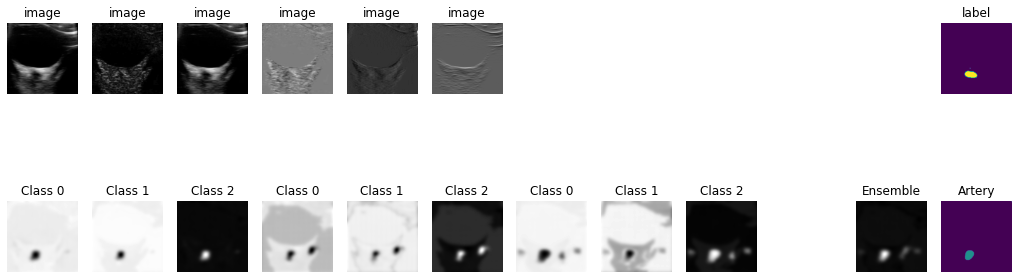

Loading dataset: 100%|██████████| 4/4 [00:01<00:00,  2.39it/s]


VFOLD = 1 of 14
Image: 2. 239.1 Right_Lat_Video 1_cropM.nii.gz
(4, 1, 224, 224)
(224, 224)


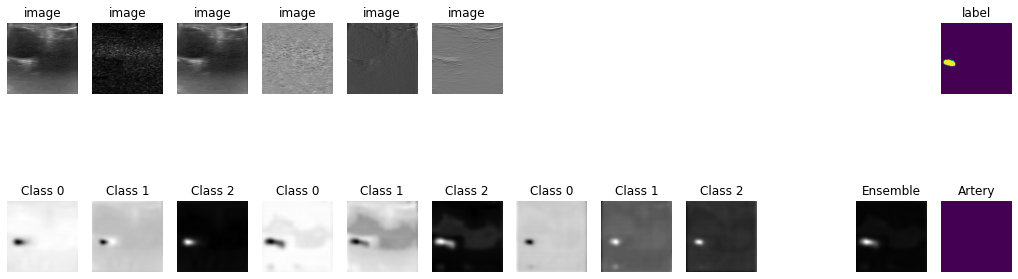

Image: 4. 23.1 Right_Long_Video 1_cropM.nii.gz
(4, 1, 224, 224)
(224, 224)


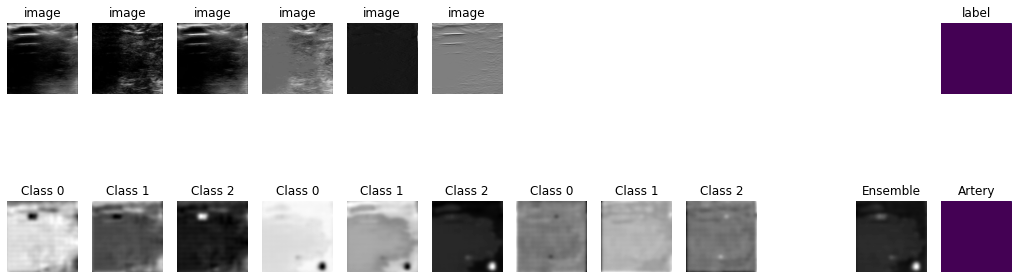

Image: 7. 23.1 Left_Lat_Video 1_cropM.nii.gz
(4, 1, 224, 224)
(224, 224)


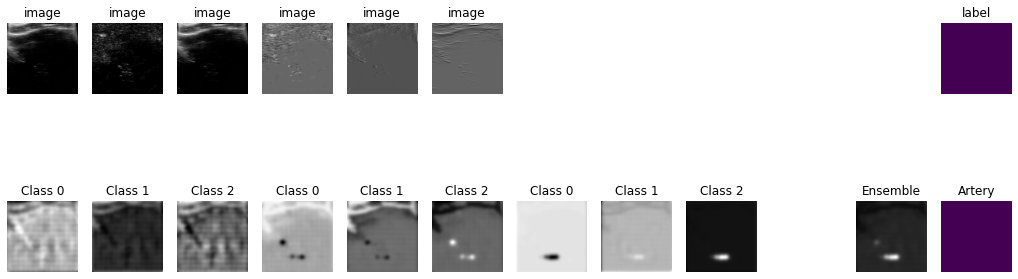

Image: 8. 23.1 Left_Lat_Video 2_cropM.nii.gz
(4, 1, 224, 224)
(224, 224)


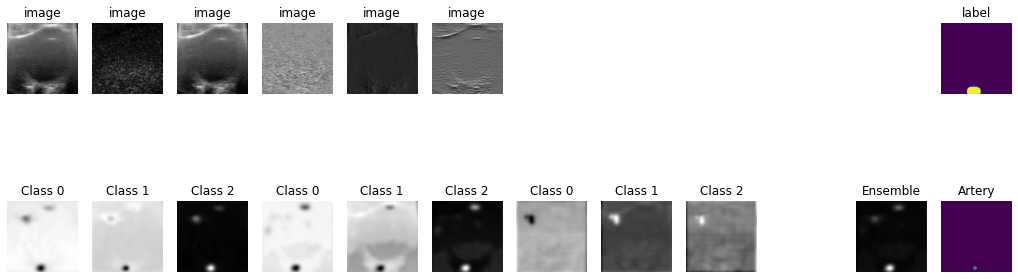

Loading dataset: 100%|██████████| 2/2 [00:00<00:00,  2.39it/s]


VFOLD = 2 of 14
Image: 4. 36.1 Right Long_Video 1_cropM.nii.gz
(2, 1, 224, 224)
(224, 224)


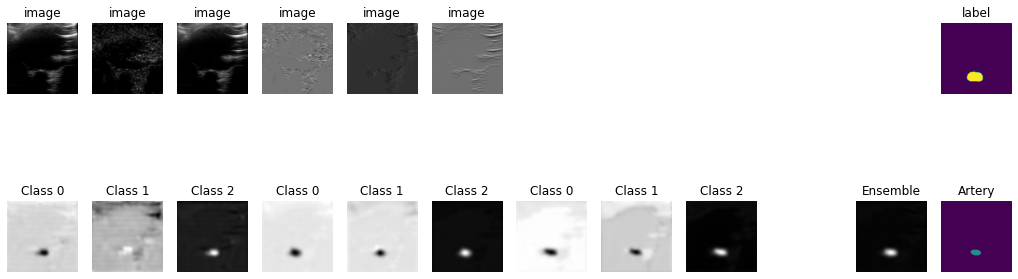

Image: 7. 108.1 Left_Lat_Video 1_cropM.nii.gz
(2, 1, 224, 224)
(224, 224)


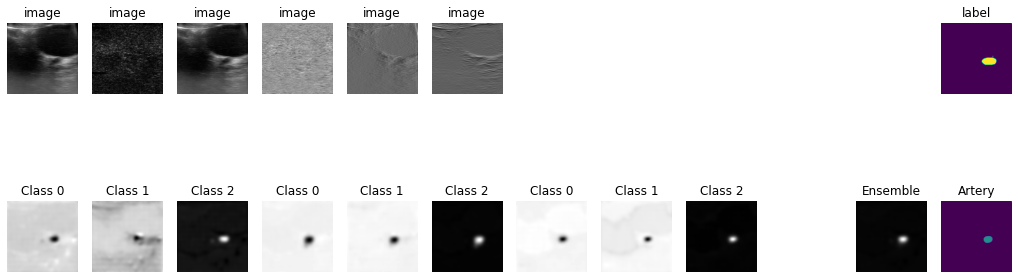

Loading dataset: 100%|██████████| 2/2 [00:01<00:00,  1.60it/s]


VFOLD = 3 of 14
Image: 2. 119.1 Right_Lat_Video 1_cropM.nii.gz
(2, 1, 224, 224)
(224, 224)


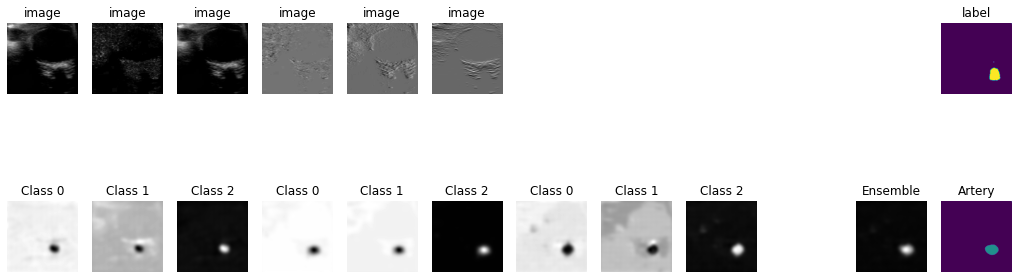

Image: 8. 40.1 Left Long_Video 1_cropM.nii.gz
(2, 1, 224, 224)
(224, 224)


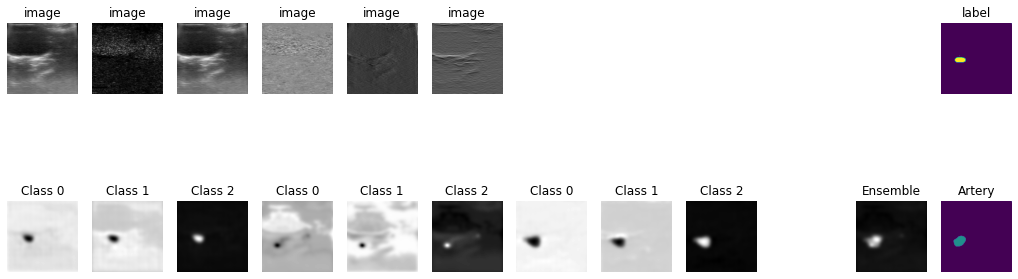

Loading dataset: 100%|██████████| 2/2 [00:00<00:00,  2.25it/s]


VFOLD = 4 of 14
Image: 2. 50.3 Right_Lat_Video 1_cropM.nii.gz
(2, 1, 224, 224)
(224, 224)


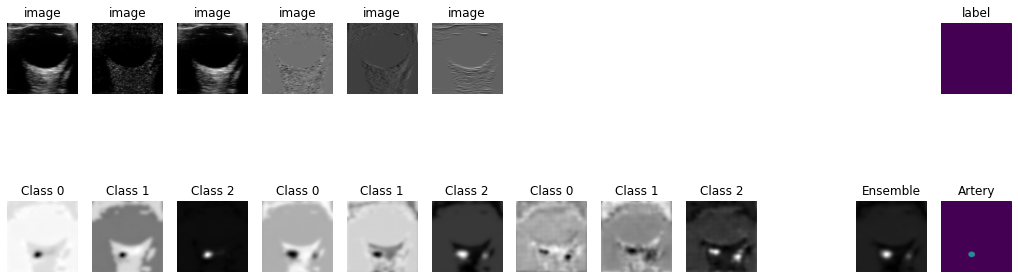

Image: 6. 129.1 Left_Lat_Video 1_cropM.nii.gz
(2, 1, 224, 224)
(224, 224)


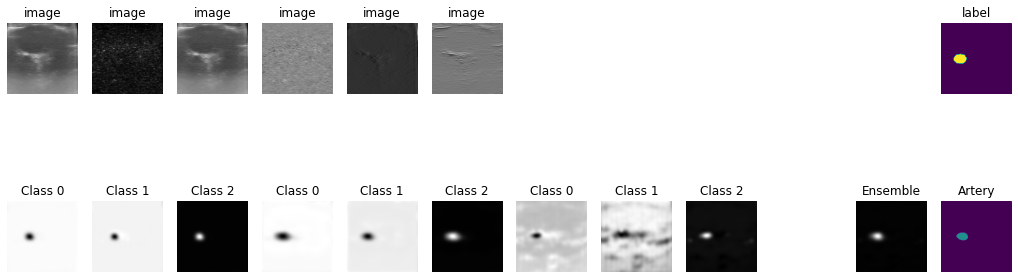

Loading dataset: 100%|██████████| 2/2 [00:01<00:00,  1.68it/s]


VFOLD = 5 of 14
Image: 2. 163.2 Right_Lat_Video 1_cropM.nii.gz
(2, 1, 224, 224)
(224, 224)


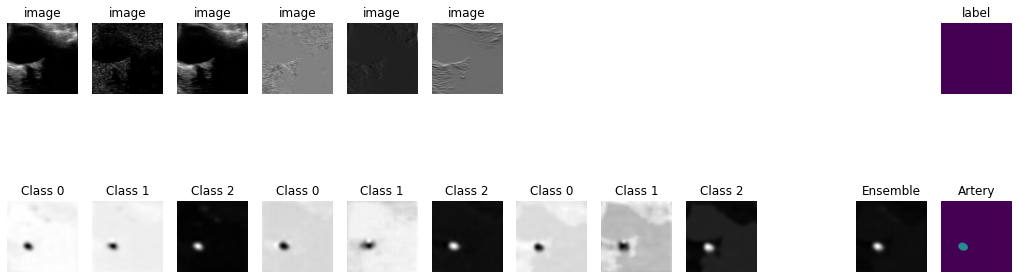

Image: 2. 64.1 Right Lat_Video 1_cropM.nii.gz
(2, 1, 224, 224)
(224, 224)


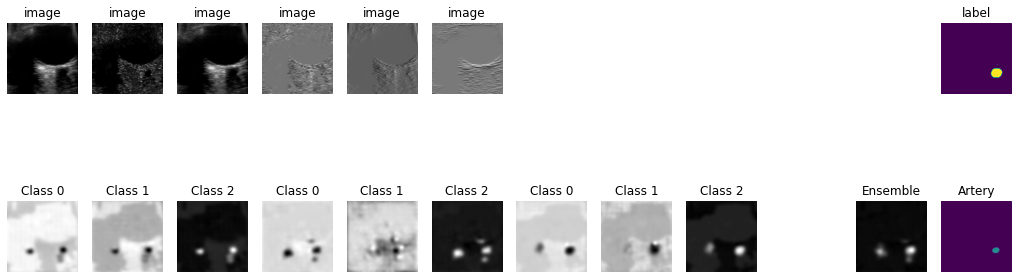

Loading dataset: 100%|██████████| 2/2 [00:01<00:00,  1.73it/s]


VFOLD = 6 of 14
Image: 4. 191.1 Right Long_Video 1_cropM.nii.gz
(2, 1, 224, 224)
(224, 224)


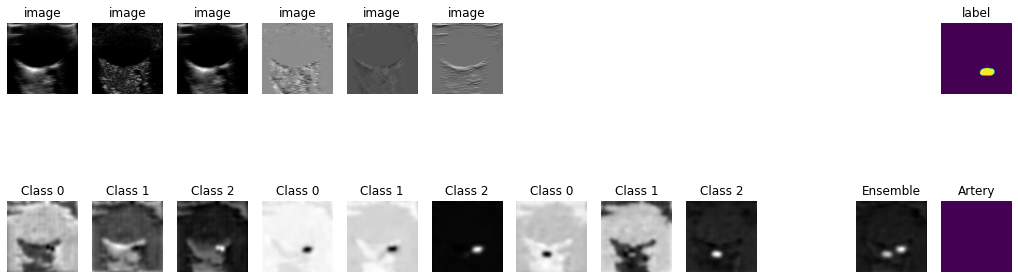

Image: 4. 66.1 Right_Long_Video 1_cropM.nii.gz
(2, 1, 224, 224)
(224, 224)


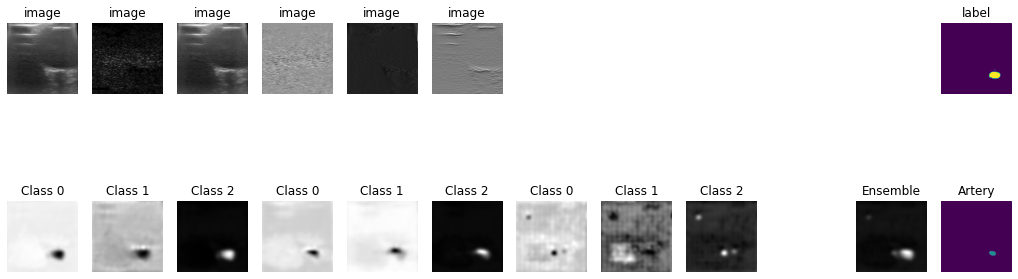

Loading dataset: 100%|██████████| 2/2 [00:00<00:00,  2.14it/s]


VFOLD = 7 of 14
Image: 2. 228.1 Right Lat_Video 1_cropM.nii.gz
(2, 1, 224, 224)
(224, 224)


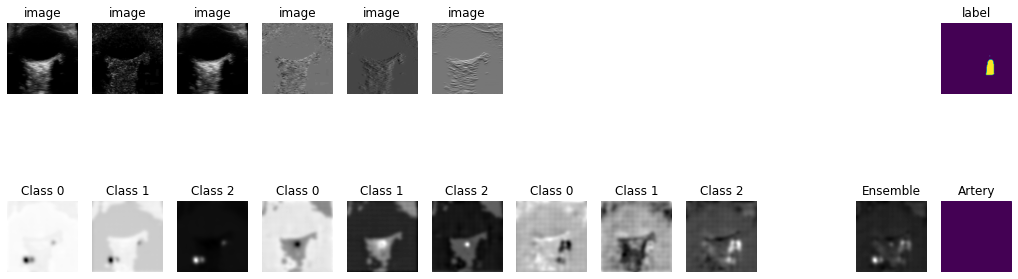

Image: 4. 87.2 Right Long_Video 1_cropM.nii.gz
(2, 1, 224, 224)
(224, 224)


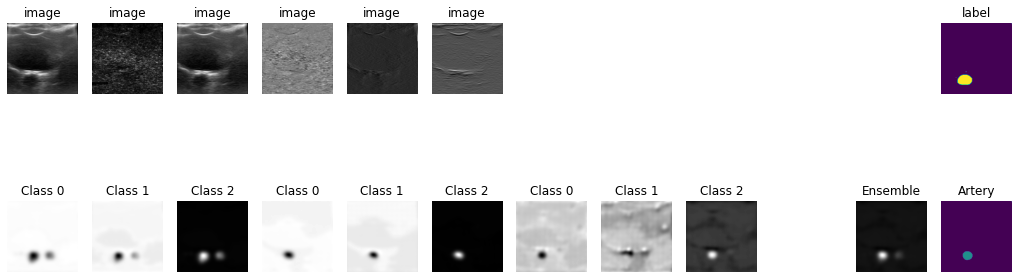

Loading dataset: 100%|██████████| 4/4 [00:01<00:00,  2.62it/s]


VFOLD = 8 of 14
Image: 10. 250.1 Left Lat_Video 1_cropM.nii.gz
(4, 1, 224, 224)
(224, 224)


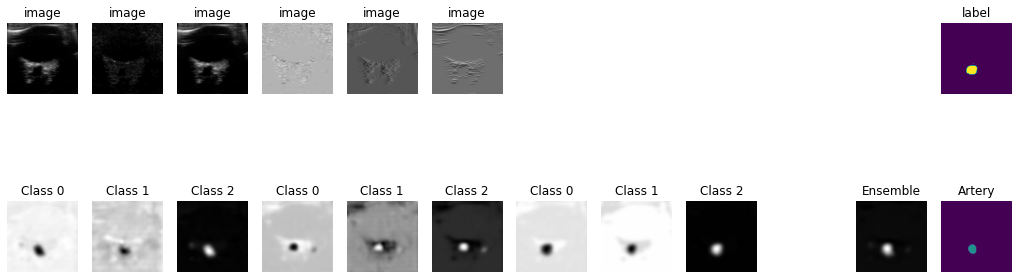

Image: 11. 106.1 Left Long Video 1_cropM.nii.gz
(4, 1, 224, 224)
(224, 224)


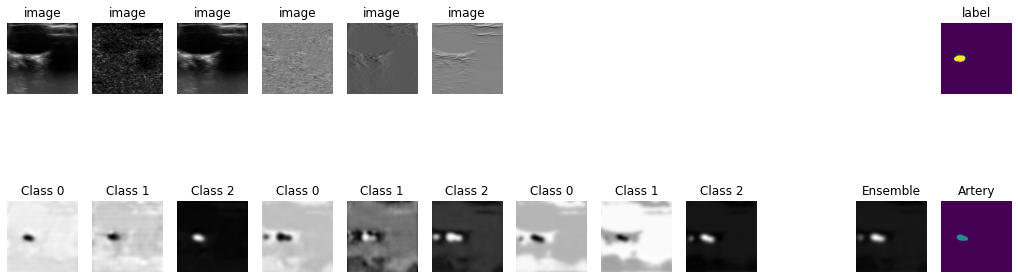

Image: 15. 250.1 Left Long_Video 1_cropM.nii.gz
(4, 1, 224, 224)
(224, 224)


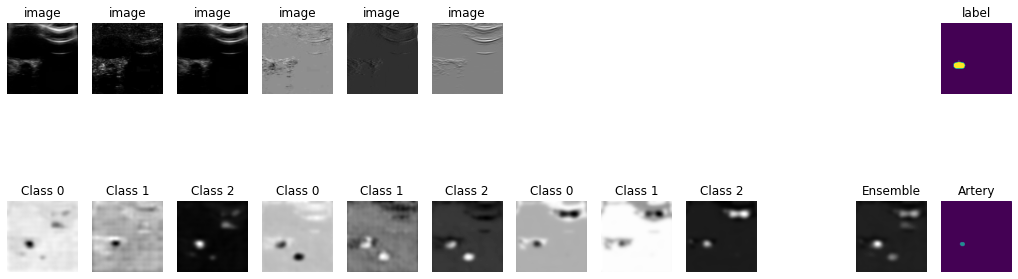

Image: 3. 250.1 Right Lat_Video 2_cropM.nii.gz
(4, 1, 224, 224)
(224, 224)


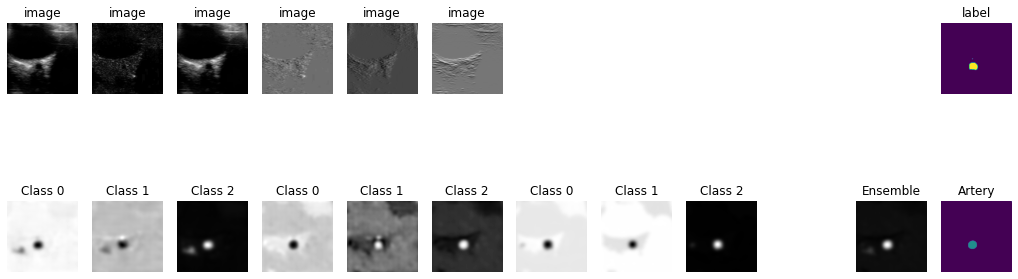

Loading dataset: 100%|██████████| 2/2 [00:00<00:00,  2.22it/s]


VFOLD = 9 of 14
Image: 6. 117.1 Left Lat_Video 1_cropM.nii.gz
(2, 1, 224, 224)
(224, 224)


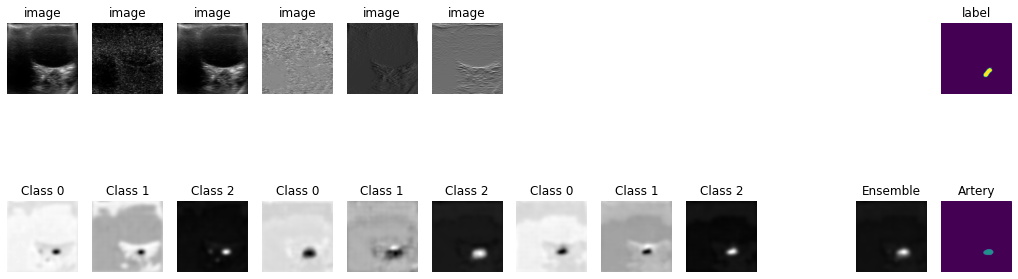

Image: 8. 205.1 Left Long_Video 1_cropM.nii.gz
(2, 1, 224, 224)
(224, 224)


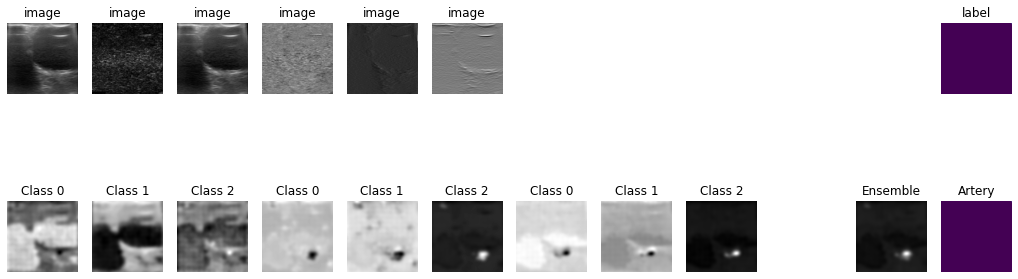

Loading dataset: 100%|██████████| 2/2 [00:00<00:00,  2.39it/s]


VFOLD = 10 of 14
Image: 4. 139.1 Right Long_Video 1_cropM.nii.gz
(2, 1, 224, 224)
(224, 224)


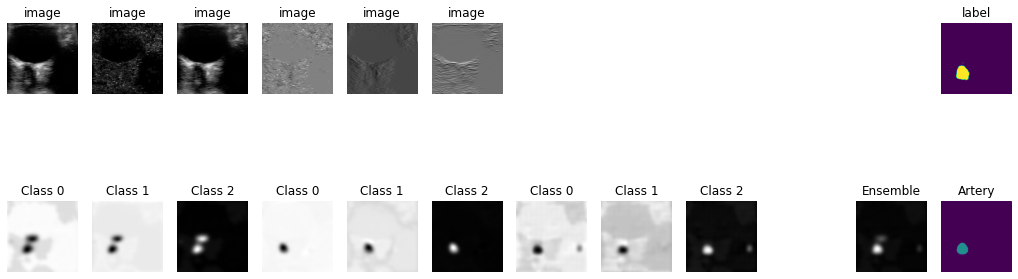

Image: 9. 209.1 Left_Long_Video 1_cropM.nii.gz
(2, 1, 224, 224)
(224, 224)


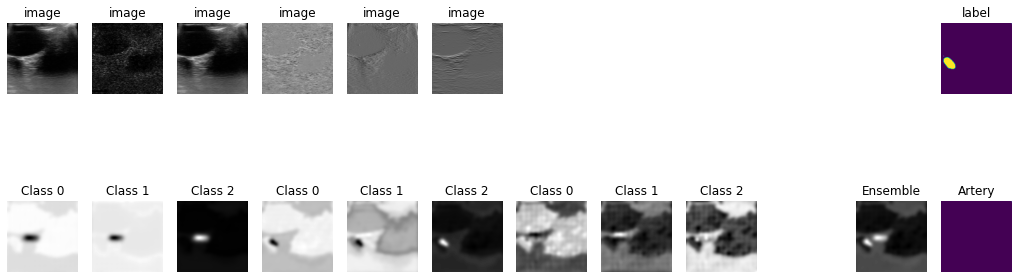

Loading dataset: 100%|██████████| 2/2 [00:00<00:00,  2.21it/s]


VFOLD = 11 of 14
Image: 2. 158.1 Right_Lat_Video 1_cropM.nii.gz
(2, 1, 224, 224)
(224, 224)


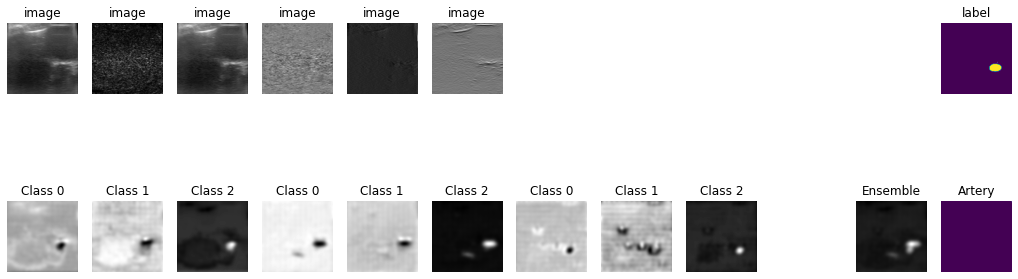

Image: 9. 213.1 Left Long_Video 1_cropM.nii.gz
(2, 1, 224, 224)
(224, 224)


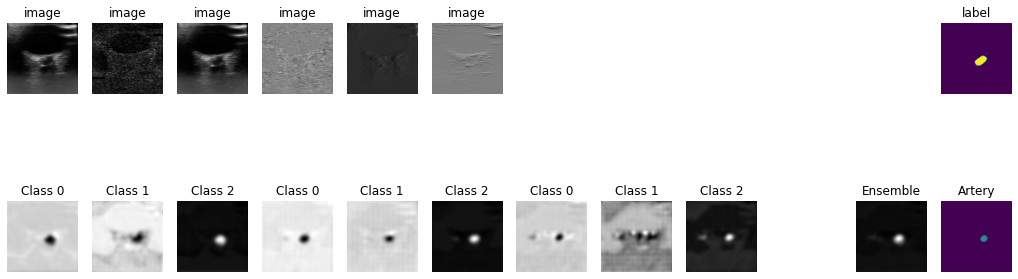

Loading dataset: 100%|██████████| 2/2 [00:00<00:00,  2.04it/s]


VFOLD = 12 of 14
Image: 2. 165.4 Right_Lat_Video 1_cropM.nii.gz
(2, 1, 224, 224)
(224, 224)


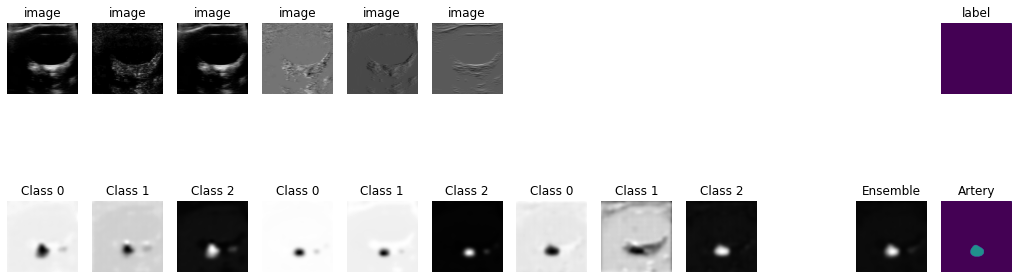

Image: 6. 215.2 Left_Lat_Video 1_cropM.nii.gz
(2, 1, 224, 224)
(224, 224)


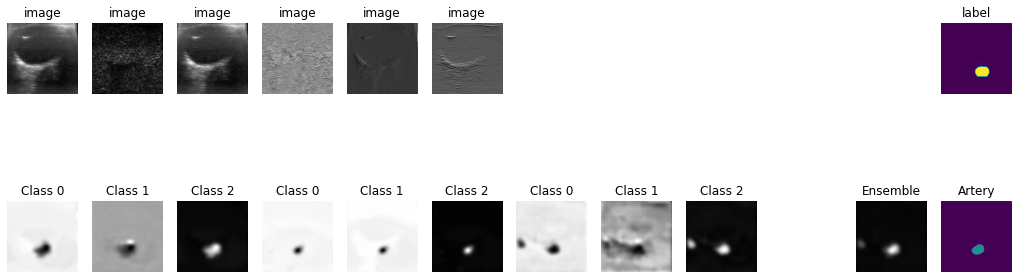

Loading dataset: 100%|██████████| 1/1 [00:00<00:00,  1.50it/s]


VFOLD = 13 of 14
Image: 8. 107.1 Left Long_Video 1_cropM.nii.gz
(1, 1, 224, 224)
(224, 224)


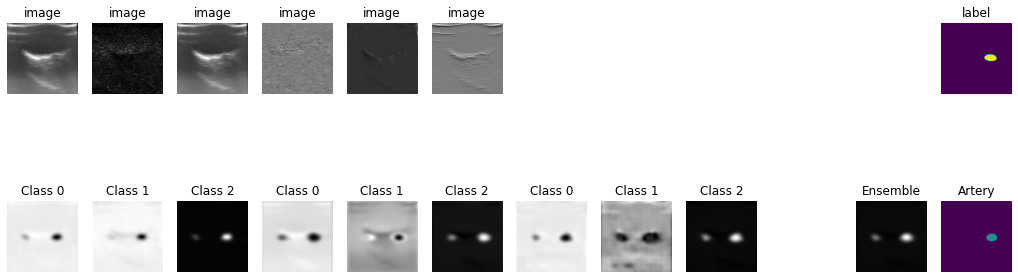

Loading dataset: 100%|██████████| 2/2 [00:00<00:00,  2.02it/s]


VFOLD = 14 of 14
Image: 6. 130.1 Left_Lat_Video 1_cropM.nii.gz
(2, 1, 224, 224)
(224, 224)


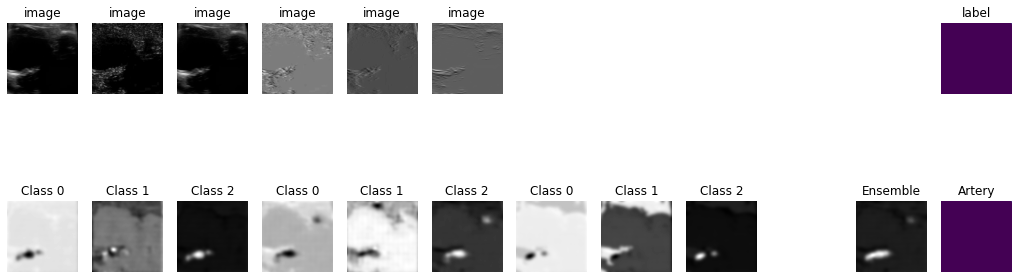

Image: 7. 130.1 Left_Lat_Video 2_cropM.nii.gz
(2, 1, 224, 224)
(224, 224)


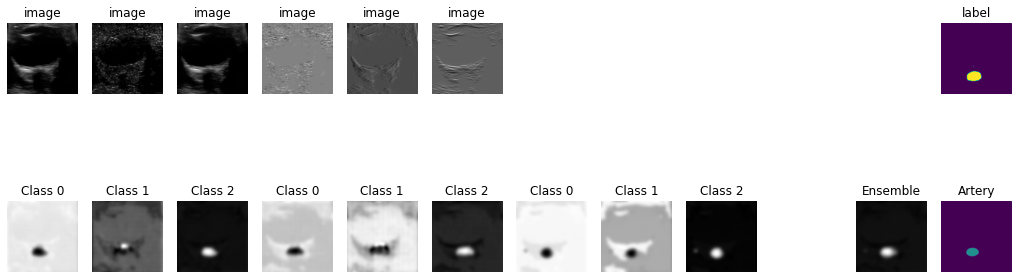

In [9]:
for i in range(0,num_folds,num_devices):
    test_ds = CacheDataset(data=test_files[i], transform=test_transforms,cache_rate=1.0, num_workers=num_workers_te)
    test_loader = DataLoader(test_ds, batch_size=batch_size_te, num_workers=num_workers_te)
    plot_vfold_training_curves(i,test_loader)
    test_loader.dataset._cache.clear()

In [10]:
import ipyparams
currentNotebook = "ARViTUNet-EnsembleClassPriorsTest-Mean_Std_RawFrame_Gradient-224x224-3s.ipynb"
exp = "ARViTUNet-EnsembleClassPriorsTest-Mean_Std_RawFrame_Gradient-224x224-3s"

from datetime import datetime
now = datetime.now()
print(str(currentNotebook))
experimentName = exp+now.strftime("-%Y.%m.%d_%H.%M")
print(experimentName)
cmd = "jupyter nbconvert "+currentNotebook+" --output "+experimentName+" --to pdf"
import subprocess
subprocess.call(cmd, shell=True)

<IPython.core.display.Javascript object>

ARViTUNet-EnsembleClassPriorsTest-Mean_Std_RawFrame_Gradient-224x224-3s.ipynb
ARViTUNet-EnsembleClassPriorsTest-Mean_Std_RawFrame_Gradient-224x224-3s-2022.11.20_21.55


[NbConvertApp] Converting notebook ARViTUNet-EnsembleClassPriorsTest-Mean_Std_RawFrame_Gradient-224x224-3s.ipynb to pdf
[NbConvertApp] Support files will be in ARViTUNet-EnsembleClassPriorsTest-Mean_Std_RawFrame_Gradient-224x224-3s-2022.11.20_21.55_files/
[NbConvertApp] Making directory ./ARViTUNet-EnsembleClassPriorsTest-Mean_Std_RawFrame_Gradient-224x224-3s-2022.11.20_21.55_files
[NbConvertApp] Making directory ./ARViTUNet-EnsembleClassPriorsTest-Mean_Std_RawFrame_Gradient-224x224-3s-2022.11.20_21.55_files
[NbConvertApp] Making directory ./ARViTUNet-EnsembleClassPriorsTest-Mean_Std_RawFrame_Gradient-224x224-3s-2022.11.20_21.55_files
[NbConvertApp] Making directory ./ARViTUNet-EnsembleClassPriorsTest-Mean_Std_RawFrame_Gradient-224x224-3s-2022.11.20_21.55_files
[NbConvertApp] Making directory ./ARViTUNet-EnsembleClassPriorsTest-Mean_Std_RawFrame_Gradient-224x224-3s-2022.11.20_21.55_files
[NbConvertApp] Making directory ./ARViTUNet-EnsembleClassPriorsTest-Mean_Std_RawFrame_Gradient-224x

0